# iForest

In [1]:
import warnings
warnings.filterwarnings('ignore')

## General libraries

In [2]:
import os
import sys

import pandas as pd
import numpy as np

from os.path import join
import json
import datetime

import shap
from shap_selection import feature_selection

from sklearn.preprocessing import OneHotEncoder
import time

### Load enviroment variables

In [3]:
from dotenv import load_dotenv
load_dotenv('../.env')

code_root = os.environ['CODE_ROOT']
cfg_path = os.environ['CFG_PATH']
data_root = os.environ['DATA_ROOT']

sys.path.insert(0, code_root)

### Specific libraries

In [4]:
from src.load.functions import get_fs_dataset, fs_datasets_hyperparams
from src.plots.functions import plot_3d_surface
from src.optimization.functions import opt_value

# if we want to create an iteractive plot or not
from mpl_toolkits.mplot3d import Axes3D
%matplotlib widget

## Arrhythmia

**Dataset source**: http://odds.cs.stonybrook.edu/arrhythmia-dataset/ (data is transformed from .mat to .csv format)

Shebuti Rayana (2016). ODDS Library [http://odds.cs.stonybrook.edu]. Stony Brook, NY: Stony Brook University, Department of Computer Science.

**Additional sources**:

Liu, Fei Tony, Kai Ming Ting, and Zhi-Hua Zhou. “Isolation forest.” 2008 Eighth IEEE International Conference on Data Mining. IEEE, 2008.

K. M. Ting, J. T. S. Chuan, and F. T. Liu. “Mass: A New Ranking Measure for Anomaly Detection.“, IEEE Transactions on Knowledge and Data Engineering, 2009.

F. Keller, E. Muller, K. Bohm.“HiCS: High-contrast subspaces for density-based outlier ranking.” ICDE, 2012.

In [5]:
dataset_id = 'arrhythmia'

data = get_fs_dataset(dataset_id, data_root)
hyper = fs_datasets_hyperparams(dataset_id)
data.shape

(452, 275)

In [6]:
pd.pivot_table(data,
             values = 'Col1',
               index = 'y', 
              aggfunc = 'count')

,Col1
y,
0,386
1,66


In [7]:
excluded_cols = ['Col15', 'Col63', 'Col65', 'Col79', 'Col127', 'Col128','Col135', 'Col137', 'Col139','Col141','Col147', 'Col152', 'Col153', 'Col160', 'Col200', 'Col260', 'Col270']

### iForest

## Parameters

In [8]:
path_shap = os.path.join(data_root, "outputs", f"{dataset_id}_shap.parquet")

df = pd.read_parquet(path_shap)

df.head()

,n_estimators,max_feats,contamination,n_feats,n_iter,n_iter_fs,roc_auc,model_stab,shap_stab,shap_stab_ad,f1_median,recall,precision,confusion_matrix
0,1,2,0.1,8,1,1,0.586725,0.999347,"[0.9959297409039477, 1.0, 0.8548835975272534, ...","[0.9959297409039477, 0.9959297409039477, 0.995...",0.166667,0.153846,0.181818,1
1,1,3,0.1,8,1,1,0.622581,0.702220,"[0.9959297409039477, 0.8531914639370758, 0.793...","[0.9959297409039477, 0.8422260182770692, 0.844...",0.117647,0.076923,0.250000,1
2,1,4,0.1,8,1,1,0.691811,0.810630,"[0.92420986975141, 0.8585157931228247, 0.72684...","[0.92420986975141, 0.94254044954155, 0.8201756...",0.277778,0.192308,0.500000,1
3,1,6,0.1,8,1,1,0.522208,0.766701,"[0.6985267648105993, 0.5765954167956471, 0.717...","[0.6985267648105993, 0.6660709523621812, 0.530...",0.054054,0.038462,0.090909,1
4,1,8,0.1,8,1,1,0.492184,0.824888,"[0.6941038455638537, 0.6056658584681082, 0.518...","[0.6941038455638537, 0.6590775237945994, 0.588...",0.105263,0.076923,0.166667,1


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2420 entries, 0 to 2419
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   n_estimators      2420 non-null   int64  
 1   max_feats         2420 non-null   int64  
 2   contamination     2420 non-null   float64
 3   n_feats           2420 non-null   int64  
 4   n_iter            2420 non-null   int64  
 5   n_iter_fs         2420 non-null   int64  
 6   roc_auc           2420 non-null   float64
 7   model_stab        2420 non-null   float64
 8   shap_stab         2420 non-null   object 
 9   shap_stab_ad      2420 non-null   object 
 10  f1_median         2420 non-null   float64
 11  recall            2420 non-null   float64
 12  precision         2420 non-null   float64
 13  confusion_matrix  2420 non-null   int64  
dtypes: float64(6), int64(6), object(2)
memory usage: 264.8+ KB


In [10]:
path_fi_shap = os.path.join(data_root, "outputs", f"{dataset_id}_fi_shap")
path_shap = os.path.join(data_root, "outputs", f"{dataset_id}_shap.parquet")

fi_shap_all = pd.read_parquet(path_fi_shap)
df = pd.read_parquet(path_shap)

df['shap_q1'] = df['shap_stab'].apply(lambda x: np.percentile(x, 75))
df['shap_q2'] = df['shap_stab'].apply(lambda x: np.percentile(x, 50))
df['shap_q3'] = df['shap_stab'].apply(lambda x: np.percentile(x, 25))

df['shap_ad_q2'] = df['shap_stab_ad'].apply(lambda x: np.percentile(x, 50))

df['shap_mean'] = df['shap_stab'].apply(lambda x: np.mean(x))


#df['shap_stab'] = df['shap_q2']
#df['shap_inestab'] = 1- df['shap_stab']


var = ['n_estimators', 'max_feats', 'n_feats', 'f1_median', 'precision', 'model_stab', 'shap_stab', 'shap_q2', 'shap_mean']
df = df[var]

In [11]:
#df = df[df.n_estimators<=500]

## Optimization

In [12]:
df.sort_values('precision', ascending=False).head(5)

,n_estimators,max_feats,n_feats,f1_median,precision,model_stab,shap_stab,shap_q2,shap_mean
39,1,119,119,0.461538,0.692308,0.662613,"[0.649054833744455, 0.6563808261293461, 0.6608...",0.664286,0.664254
372,7,91,152,0.625000,0.681818,0.841399,"[0.4618748447050407, 0.4835512878484983, 0.457...",0.471484,0.471335
864,16,119,119,0.612245,0.652174,0.879307,"[0.5593546393390272, 0.49108364190034026, 0.55...",0.521619,0.526178
1414,50,119,119,0.565217,0.650000,0.947261,"[0.6513426891276886, 0.5868605847731891, 0.589...",0.581130,0.594358
1418,50,121,152,0.565217,0.650000,0.941980,"[0.5953794847580258, 0.5011463151408821, 0.558...",0.532039,0.541488


In [13]:
df.shape

(2420, 9)

In [14]:
sorted_df = opt_value(df, lambda_=0.7, var2='shap_mean')

opt_x = int(sorted_df.iloc[0:1,:].n_estimators)
opt_y = int(sorted_df.iloc[0:1,:].n_feats)

sorted_df

,n_estimators,max_feats,n_feats,f1_median,precision,model_stab,shap_stab,shap_q2,shap_mean,opt_value
2398,500,75,94,0.565217,0.650000,0.992174,"[0.925741059924873, 0.8337315568032532, 0.8596...",0.856642,0.852592,0.710778
2343,475,75,94,0.565217,0.650000,0.992040,"[0.9247727953026743, 0.827049142125321, 0.8579...",0.850535,0.848847,0.709654
2178,400,75,94,0.565217,0.650000,0.991063,"[0.9123544847154558, 0.8098776505170049, 0.855...",0.841157,0.838836,0.706651
2344,475,94,94,0.553191,0.619048,0.990055,"[0.9290404445510998, 0.8366020195253386, 0.845...",0.846674,0.848372,0.687845
2288,450,75,94,0.553191,0.619048,0.991981,"[0.9223249390069794, 0.8284382442047586, 0.854...",0.848985,0.847179,0.687487
...,...,...,...,...,...,...,...,...,...,...
75,2,11,57,0.047619,0.062500,0.606226,"[0.67310737382597, 0.6927983589123545, 0.60431...",0.672959,0.674627,0.246138
20,1,11,57,0.000000,0.000000,0.665944,"[0.8242037459431402, 0.8058951954820152, 0.753...",0.816149,0.815038,0.244511
69,2,29,29,0.130435,0.150000,0.751773,"[0.3668897262024796, 0.40588161248129395, 0.39...",0.397346,0.400072,0.225022
138,3,58,73,0.088889,0.105263,0.764036,"[0.40143236863599696, 0.39602474756153094, 0.4...",0.466702,0.467918,0.214060


## Visualization of the results

In [15]:
# Find the index of the maximum 'n_feat' in each 'n_estimators' and 'n_feats' group
idx = df.groupby(['n_estimators', 'n_feats'])['max_feats'].idxmax()
# Filter the DataFrame to keep only the rows with the maximum 'n_feat' per group
df_n_trees = df.loc[idx].reset_index(drop=True)

# Find the index of the maximum 'n_feat' in each 'n_estimators' and 'n_feats' group
idx = df.groupby(['n_estimators', 'max_feats'])['n_feats'].idxmax()
# Filter the DataFrame to keep only the rows with the maximum 'n_feat' per group
df_max_feat = df.loc[idx].reset_index(drop=True)

In [16]:
df = df_n_trees.copy()

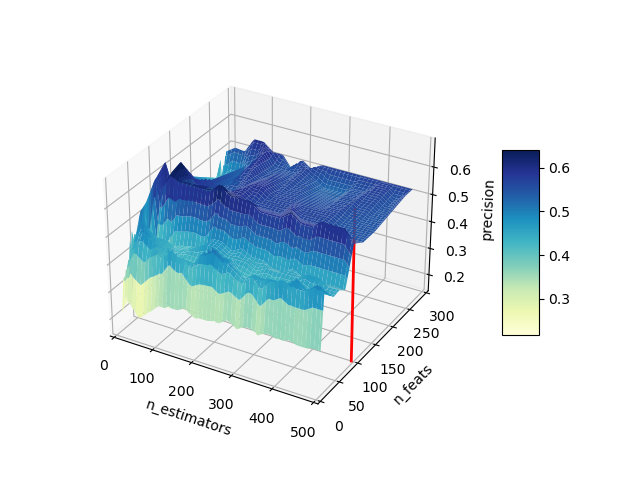

In [17]:
# Example usage (assuming 'df' is your DataFrame)
plot_3d_surface(df, 'n_estimators', 'n_feats', 'precision', cmap='YlGnBu', x_step=100, y_step=50, opt_x=opt_x, opt_y=opt_y, opt_color='red')


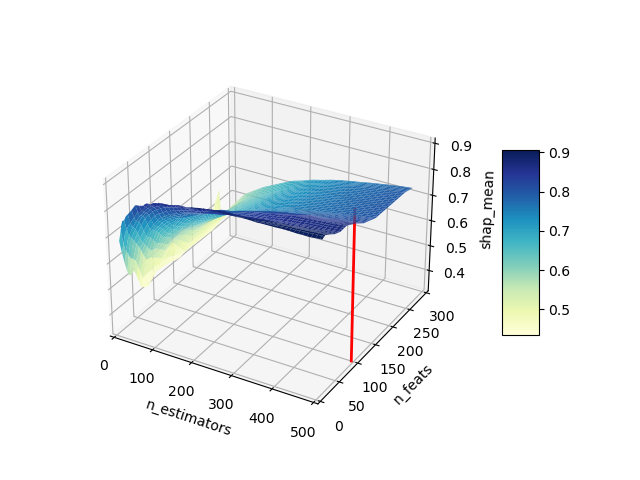

In [18]:
# Example usage (assuming 'df' is your DataFrame)
plot_3d_surface(df, 'n_estimators', 'n_feats', 'shap_mean', cmap='YlGnBu', x_step=100, y_step=50, opt_x=opt_x, opt_y=opt_y, opt_color='red')

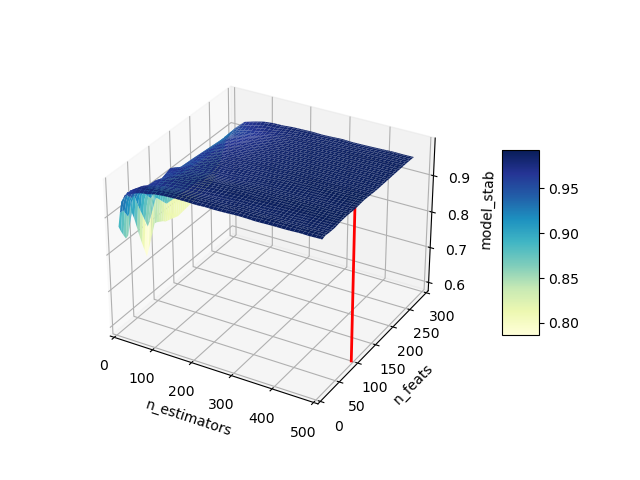

In [19]:
# Example usage (assuming 'df' is your DataFrame)
plot_3d_surface(df, 'n_estimators', 'n_feats', 'model_stab', cmap='YlGnBu', x_step=100, y_step=50, opt_x=opt_x, opt_y=opt_y, opt_color='red')


In [20]:
df = df[df.max_feats == df.n_feats]

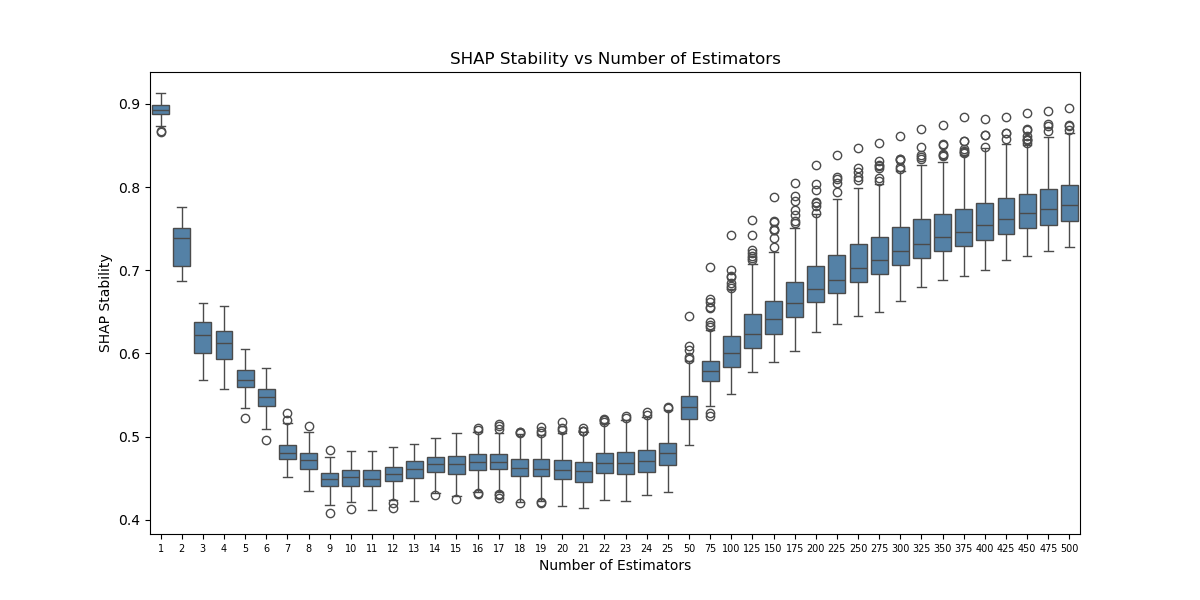

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Sample data simulating the user's dataframe structure.
# For demonstration purposes, we use random data here.
# The user would replace this with their actual dataframe.

# Choosing the row with the highest max_feats and n_feats for each n_estimator
selected_rows = df.sort_values(by=['max_feats', 'n_feats'], ascending=[False, False]).drop_duplicates(['n_estimators'])

# Exploding the list in 'shap_stab' into separate rows.
df_exploded = selected_rows.explode('shap_stab')

# Convert 'shap_stab' to numeric as it might be read as object due to the list.
df_exploded['shap_stab'] = pd.to_numeric(df_exploded['shap_stab'])

# Creating a boxplot with 'n_estimators' on the x-axis and 'shap_stab' values on the y-axis.
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_exploded, x='n_estimators', y='shap_stab', color='steelblue')

# Adjusting the size of the x-axis labels
plt.xticks(fontsize=7)

# Additional plot formatting, if necessary
plt.title('SHAP Stability vs Number of Estimators')
plt.xlabel('Number of Estimators')
plt.ylabel('SHAP Stability')
plt.show()


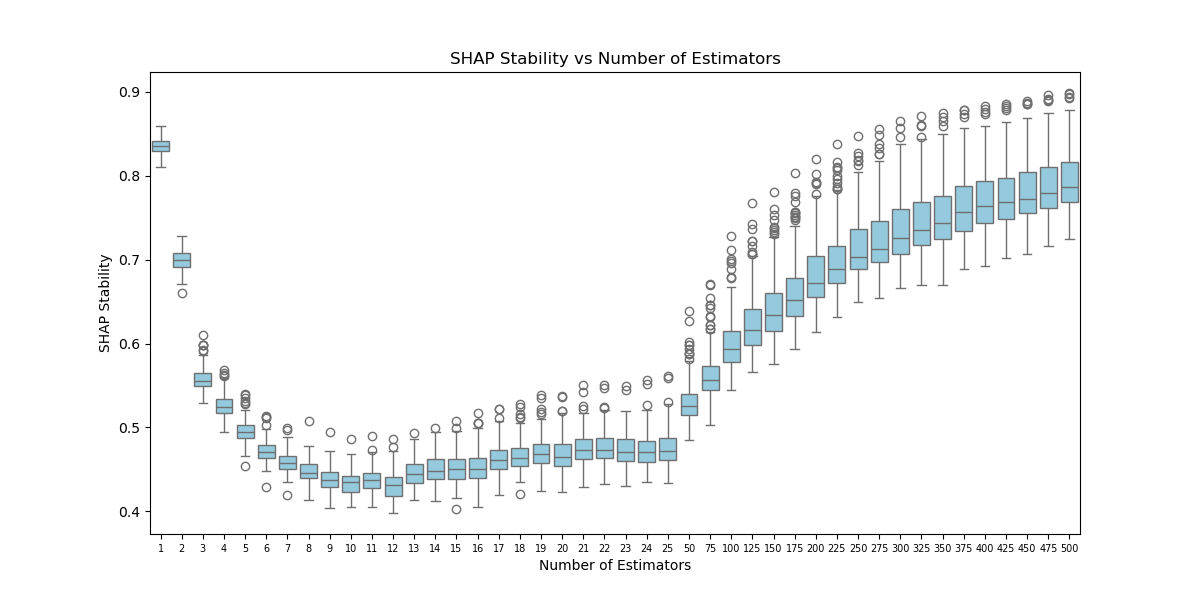

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Sample data simulating the user's dataframe structure.
# For demonstration purposes, we use random data here.
# The user would replace this with their actual dataframe.

# Sort the dataframe by 'n_estimators' and then 'n_feats' in descending order.
df_sorted = df.sort_values(by=['n_estimators', 'n_feats'], ascending=[True, False])

# For each group of 'n_estimators', select the second highest 'n_feats'.
# This can be done by grouping by 'n_estimators' and then using 'nth' to select the second item.
selected_rows = df_sorted.groupby('n_estimators').nth(1).reset_index()

# Exploding the list in 'shap_stab' into separate rows.
df_exploded = selected_rows.explode('shap_stab')

# Convert 'shap_stab' to numeric as it might be read as object due to the list.
df_exploded['shap_stab'] = pd.to_numeric(df_exploded['shap_stab'])

# Creating a boxplot with 'n_estimators' on the x-axis and 'shap_stab' values on the y-axis.
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_exploded, x='n_estimators', y='shap_stab', color='skyblue')

# Adjusting the size of the x-axis labels
plt.xticks(fontsize=7)

# Additional plot formatting, if necessary
plt.title('SHAP Stability vs Number of Estimators')
plt.xlabel('Number of Estimators')
plt.ylabel('SHAP Stability')
plt.show()

